In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from riken.protein_io import data_op
from riken.rnn import rnn_hyperparameters_search
from riken.nn_utils import records_maker

safe_char_to_idx = rnn_hyperparameters_search.safe_char_to_idx
n_chars = rnn_hyperparameters_search.n_chars

DATA_PATH = '/home/pierre/riken/data/riken_data/complete_from_xlsx.tsv'
KEY_TO_PREDICT = 'is_allergenic'
MAXLEN = 500
log_dir = './logs_rnn_v2_transfer_new_attention_it38_DATA_AUGMENTATION/weights.04-0.92.hdf5'
# log_dir = './logs_rnn_v2_transfer_new_attention_it38/weights.04-0.52.hdf5'

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t').dropna()
df = df.loc[df.seq_len >= 50, :]
df.loc[:, 'sequences'] = df.sequences
sequences, y = df['sequences'].values, df[KEY_TO_PREDICT]
y = pd.get_dummies(y).values
X = pad_sequences([[safe_char_to_idx(char) for char in sequence] for sequence in sequences], maxlen=MAXLEN)
groups = df.species.values
features = np.array([records_maker.get_feat(tokens) for tokens in X])
train_inds, test_inds = data_op.group_shuffle_indices(X, y, groups)
Xtrain, Xtest, ytrain, ytest = X[train_inds], X[test_inds], y[train_inds], y[test_inds]
features_train, features_test = features[train_inds], features[test_inds]

model = load_model(log_dir)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aa_indice (InputLayer)          (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 25)      625         aa_indice[0][0]                  
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 42)      1050        aa_indice[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 500, 67)      0           embedding_1[0][0]                
                                                                 embedding_2[0][0]                
__________

In [4]:
print(Xtrain.shape, Xtest.shape)

(11141, 500) (1325, 500)


In [5]:
ypred = model.predict(Xtest)
ypred = ypred[:, 1]
ytest = ytest[:, 1]

In [16]:
import matplotlib.pyplot as plt
import sys; sys.path.append("../word2vec")
import classification_tools
from sklearn.metrics import classification_report


classification_tools.roc_score(ytest, ypred)
plt.legend()
# plt.savefig('/home/pierre/riken/misc/roc_curve_without_DA_5_epochs.png')
plt.show()

thresh = .3
print(classification_report(ytest, ypred >= thresh))

In [20]:
df_small = pd.read_csv(DATA_PATH, sep='\t').dropna()
df_small = df_small.loc[df_small.seq_len < 50, :]
sequences_small, y_small = df_small['sequences'].values, df_small[KEY_TO_PREDICT]
y_small = pd.get_dummies(y_small).values
X_small = pad_sequences([[safe_char_to_idx(char) for char in sequence] for sequence in sequences_small], maxlen=MAXLEN)


ypred_small = model.predict(X_small)
ypred_small = ypred_small[:, 1]
ytest_small = y_small[:, 1]

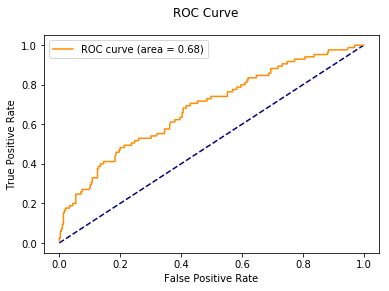

             precision    recall  f1-score   support

          0       0.81      0.95      0.87       295
          1       0.53      0.21      0.30        85

avg / total       0.74      0.78      0.74       380



In [23]:
classification_tools.roc_score(ytest_small, ypred_small)
plt.legend()
# plt.savefig('/home/pierre/riken/misc/roc_curve_without_DA_5_epochs.png')
plt.show()

thresh = .5
print(classification_report(ytest_small, ypred_small >= thresh))

# Attention Vis

In [ ]:
Xtest

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from riken.viz_utils import visualize_attention

attention = model.get_layer(name='activation_1').output
attention_model = Model(inputs=model.inputs, outputs=attention)

In [ ]:
ypred[50]

In [ ]:
# for idx in range(100):
#     ex = Xtest[idx, :]
# #     print(ytest[idx])
#     print(idx, len(sequences[idx]))

idx = 30
# idx = 2
ex = Xtest[idx, :]
print('is allergen', ytest[idx])
print('good prediction', (ypred[idx] >= 0.5)==ytest[idx])
print('seq len', len(sequences[idx]))

In [ ]:
att_val = attention_model.predict(ex.reshape(1, -1)).reshape(-1)
fig, ax = plt.subplots(figsize=(20, 3))
ax = visualize_attention(sequences[idx], att_val, False)
ax.set_title('Attention visualization for allergen protein sequence')

fig.savefig('attention_vis.png')

In [ ]:
where_to_look = np.argmax(att_val[-len(sequences[idx]):])

print(sequences[idx][where_to_look-10:where_to_look], ' ', 
      sequences[idx][where_to_look], 
      ' ', sequences[idx][where_to_look+1:where_to_look+10])

Let's take 5 examples and see if patterns are coherent


In [ ]:
np.random.choice(range(423), size=5)

    idx=173
    good prediction
    ENVG   G   NGGP
    no match

    idx=372
    good prediction
    VSDA   L   EGKD
    LE match but not good sign

    idx=182
    bad prediction
    KITF   P   EGSP
    FP match but not good sign

    idx=400
    good prediction
    ANGD   G   TISS
    GDG match and good sign
    DGT match but not good sign

    idx=2
    good prediction
    LMCE   I   EGNY
    IEG match and good sign
    CEI match and good sign

# Analysis of wrong predictions

In [8]:
ypred

array([9.9199182e-01, 9.6706903e-01, 1.8616079e-01, ..., 1.5388595e-01,
       1.1236230e-02, 3.9445359e-04], dtype=float32)

In [56]:
is_wrong = (ypred >= 0.5) != ytest
test_df = df.iloc[test_inds]
test_df.loc[:, 'is_misclassified'] = is_wrong
misclassifications = test_df.loc[test_df.is_misclassified]

/home/pierre/miniconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pierre/miniconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
gp_sizes = df.iloc[test_inds].groupby('species').size()
gp_sizes.name = 'Number of overall examples'
gp_mean_len = df.iloc[test_inds].groupby('species').seq_len.mean()



gped = misclassifications.groupby('species')

perc_misclas = gped.sequences.size() / gp_sizes
perc_misclas.name = 'Misclassification percentage'

gp_mean_len_misclass = gped.seq_len.mean()
gp_mean_len_misclass.name = 'seq_len misclassified'

pd.concat([perc_misclas, gp_sizes, gp_mean_len, gp_mean_len_misclass], axis=1, sort=True).dropna()

,Misclassification percentage,Number of overall examples,seq_len,seq_len misclassified
aestivum,0.255172,435,301.422989,269.270270
albacares,0.500000,2,398.000000,364.000000
alternata,0.315789,19,223.315789,212.333333
cacti,1.000000,1,335.000000,335.000000
commune,1.000000,1,576.000000,576.000000
deliciosa,0.342857,35,230.971429,196.416667
esculenta,0.200000,5,171.400000,110.000000
esculentum,0.177778,45,332.622222,359.500000
familiaris,0.500000,6,261.666667,210.666667
franciscana,0.040000,25,341.280000,356.000000


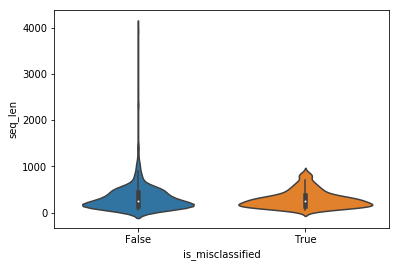

In [60]:
import seaborn as sns

sns.violinplot(x='is_misclassified', y='seq_len', data=test_df)

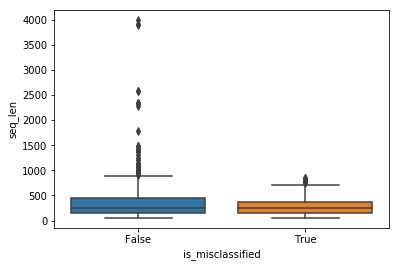

In [61]:
sns.boxplot(x='is_misclassified', y='seq_len', data=test_df)

Nothing seems abnormal.